## Paper ages

In [61]:
paper_down_ages = ['GDF8','GADD45G','LOC340156','SGK','MYH4','ARRDC2','NANOS1','MLF1','PRKAG3','PDLIM7','LOC285556','LOC154092','RNF13','DKFZP434C171','LDHA','KIAA1161','ALS2CR2','LOC283491','SCN4B','FLJ10925','TMEPAI','ESPN','PAK1','RALY','MORC','FLJ32356','PLCD4','FLJ36748','LGALS9','AK1','LOC121952','KIAA1666','ZNF32','FRMD3','IGFBP5','ST18','LASS5','GPX2','FAM31C','PGK1','KCNN1','ADAM23','DNAJC13','SPATA12','CST11','SCUBE2','CNNM3','KLHDC3','MMP7','LOC203076','DUSP13','MOBP','F-LANa','FMR2','NGL-1','F5','GPR75','SIX2','OR10H3','CASQ1','FLJ23529','IHPK2','ANKRD19','HIST1H3E','GALNT11','C18orf1','TTL','LOC222070','ZNF511','MOCS2','VLDLR','FLJ10700','OPN4','LOC286178','FLJ13052','DOCK7','TNFRSF19L','C21orf124','LOC222070','LOC201164','MGC48935','FLJ33674','LOC90499','C20orf44','MGC40574','LOC220929','PPP1R9B','FGF19','KLF1','LOC285498','PRO1905','FLJ11753']
paper_up_ages   = ['TOR2A','LOC90701','TAF1','ZNF285','MGC29875','ZNF3','TAS2R8','CCNT2','MGC27345','GDAP1','MGC22265','HGS','GCHFR','GNPDA1','PRKDC','INPP5E','MGC45416','KIAA1272','ZNF226','HSMPP8','NP220','C14orf94','HPGD','APBB3','FLJ10377','CIP29','CLK2','TRIB3','BTC','MKRN4','SRP46','MGC5306','TPR','FLJ12895','MGC19764','ATP8B1','LOC90624','CHCHD7','ABCA6','CD163','NPHS1','NPD014','ORC3L','GALNTL2','LOC283232','MGC3067','WDR17','DKFZp434E0519','PRG4','MASK-BP3','PRODH','USP54','LOC285147','DLEU2','PNRC2','FUSIP1','CDKN2B','FIGF','MYH11','SIX5','FANCE','FLJ43663','PLAT','RAB45','BEX2','FLJ10178','ZNF404','FLJ22655','PLA2G2A','ARID5A','PLA1A','SOX9','ABHD3','ADH1B','NNMT','PLAG1','CYP26B1','KIAA1799','MYH3']
paper_genes = paper_down_ages + paper_up_ages

## Import

In [9]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cross_validation import train_test_split, LeaveOneOut,cross_val_score, cross_val_predict
from multiprocessing import Pool
from scipy.stats import pearsonr


## Data

In [84]:
ds = pd.read_table('../data/age-biomarkers/GSE28422_gcrma_qnorm.txt', sep=' ')
ds.columns = [c.replace('.CEL.gz', '').replace('_y', '').replace('_x', '') for c in ds.columns]
dslog2 = np.log2(ds)
print(ds.shape)
ds.head()

(18718, 110)


,GSM702435,GSM702436,GSM702437,GSM702438,GSM702439,GSM702440,GSM702441,GSM702442,GSM702461,GSM702462,...,GSM702361,GSM702362,GSM702363,GSM702364,GSM702389,GSM702390,GSM702391,GSM702392,GSM702393,GSM702394
A1BG,4.297666,4.293018,4.293018,4.388572,4.293241,4.293018,4.858169,4.293018,4.293018,4.293018,...,4.293716,4.297437,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018
A1BG-AS1,5.317007,5.220222,5.299166,4.819012,5.228063,5.319357,5.240927,5.016990,5.150995,5.234033,...,7.848879,7.397253,7.567314,7.442875,7.557124,8.940205,7.567314,7.621126,7.030840,4.993563
A1CF,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,...,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018,4.293018
A2M,11530.500749,13816.031167,14364.106764,20033.411514,16352.909454,15721.198055,15824.803334,17370.155021,14008.879589,13109.492047,...,10329.197199,15721.198055,9935.421740,13449.638380,11192.550090,12021.853504,13205.316861,13449.638380,16241.562354,11593.114238
A2M-AS1,184.151035,206.066319,156.758728,159.187899,202.393850,214.760296,281.661729,234.451731,188.533945,188.643277,...,206.301610,246.846817,252.961127,218.497243,247.296451,256.368954,238.750155,230.511775,237.161051,224.686585


In [76]:
import pymongo
db = pymongo.MongoClient().scraper_meta

def make_char(item):
    c = item['characteristics']
    res = dict(
        (k, value.lower()) for k, value in c.items() if k in ['age', 'gender', 'training state']
    )
    res['accession'] = item['accession']
    return res

characteristics = pd.DataFrame(
    data=[make_char(x) for x in db.samples.find({'series': 'GSE28422'})]
)

characteristics.head()

,accession,age,gender,training state
0,GSM702358,young,male,untrained
1,GSM702359,young,male,untrained
2,GSM702360,young,male,untrained
3,GSM702361,young,male,untrained
4,GSM702362,young,male,untrained


In [54]:
characteristics.age.value_counts()

Young    62
Old      48
dtype: int64

In [318]:
def binarize(series):
    return pd.Series(label_binarize(series, classes=series.unique()).ravel(), name=series.name, index=series.index)

chars_bin = characteristics.set_index('accession').apply(axis=0, func=binarize)
ages = chars_bin.age
# binarize(characteristics.set_index('accession').age)

In [78]:
ages.head()

accession
GSM702358    0
GSM702359    0
GSM702360    0
GSM702361    0
GSM702362    0
Name: age, dtype: int64

In [63]:
# Сколько генов в аннотации присутвует генах в статье: мало
ds[ds.index.isin(paper_genes)].index.unique().shape, len(paper_genes)

((101,), 171)

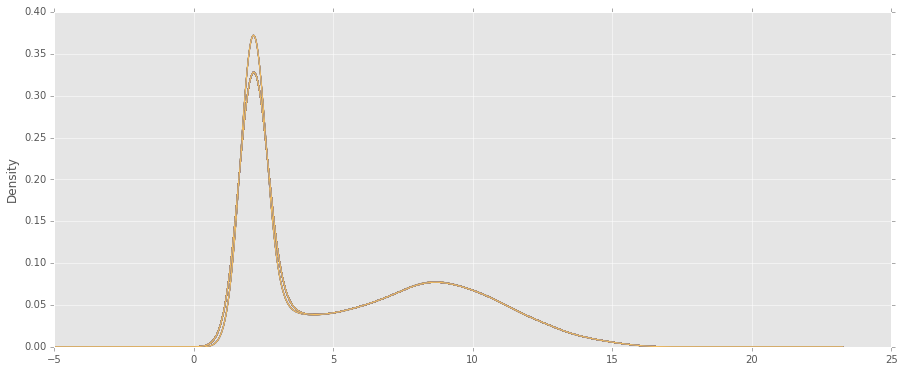

In [322]:
dslog2.plot(kind='kde', legend=False, figsize=(15, 6))

## Gene correlation

In [306]:
def cell():
    def gene_cor(gene):
        return np.abs(pearsonr(dslog2.loc[gene].values, ages.loc[dslog2.columns]))
                      
    cor = pd.DataFrame()
    cor['gene'] = dslog2.index
    cor[['cor', 'p']] = pd.DataFrame.from_records(cor.gene.map(gene_cor))
    
    return cor.sort(columns=['cor'], ascending=False)
cor_all_genes = cell()


In [ ]:
# def cell():
    _t = np.corrcoef(dslog2.to_matrix())

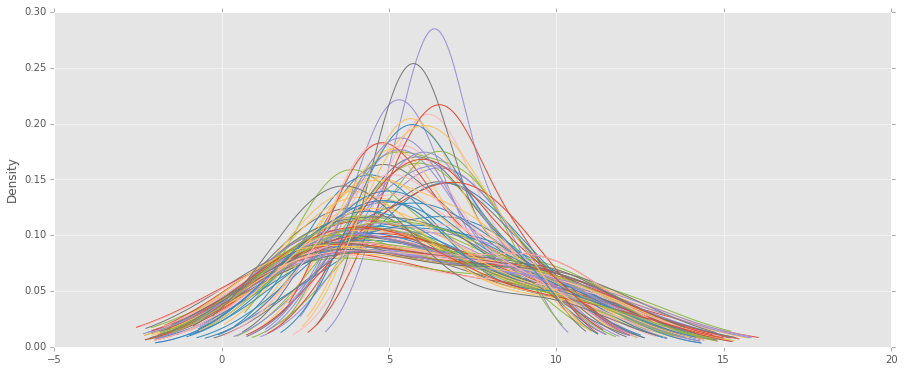

In [332]:
dslog2.loc[cor_all_genes[:5].gene].plot(kind='kde', legend=False, figsize=(15, 6))

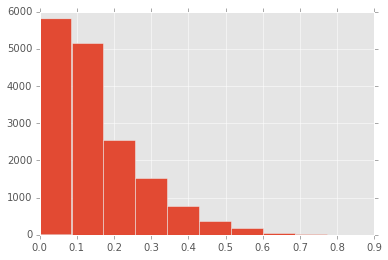

In [97]:
cor_all_genes.cor.hist()

In [98]:
top_cor_genes = cor_all_genes.sort(columns='cor', ascending=False)[:160]
top_cor_genes[:10]

,gene,cor,p
4263,DMRT2,0.859699,2.752009e-33
12443,PLAG1,0.841261,1.290558e-30
17462,UNC13C,0.816396,1.649462e-27
14128,RXRG,0.796133,2.629977e-25
14708,SKAP2,0.787372,1.980486e-24
4852,EPB41L3,0.786694,2.306343e-24
8191,KRTAP19-3,0.774444,3.293998e-23
1627,C10orf71-AS1,0.761051,5.014024e-22
15057,SLC7A6,0.744838,1.076211e-20
10747,MYH8,0.730084,1.443472e-19


## Logistic regression

In [101]:
y = ages.loc[dslog2.columns]
X = dslog2.T.as_matrix()

In [262]:
def cell():
    y = ages.loc[dslog2.columns]
    X = dslog2.loc[top_cor_genes[:20].gene].T.as_matrix()
    
    model = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    y_predict = model.fit(X_train, y_train).predict(X_test)
    
    acc = sum(map(lambda x: bool(x[0]) and bool(x[1]), zip(y_predict, y_test))) / sum(y_test)
    return acc, y_predict.tolist(), y_test.tolist()
cell()

(1.0, [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

In [292]:
from sklearn.preprocessing import label_binarize

def cell():
#     y = chars_bin['training state'].loc[dslog2.columns]
    y = chars_bin['gender'].loc[dslog2.columns]
#     y = chars_bin['age'].loc[dslog2.columns]
#     y = np.random.randint(2, size=len(dslog2.columns))
    X = dslog2.T.as_matrix()
    
    model = LogisticRegression()
    return cross_val_score(model, X, y, cv=10, n_jobs=3)
cell()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

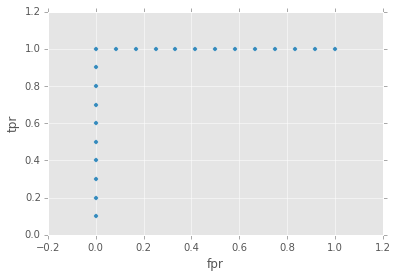

In [367]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def cell():
    model = LogisticRegression()
#     y = chars_bin['training state'].loc[dslog2.columns]
    y = chars_bin['age'].loc[dslog2.columns]
#     y = chars_bin['age'].loc[dslog2.columns]
#     y = np.random.randint(2, size=len(dslog2.columns))
    X = dslog2.loc[cor_all_genes.sort('cor')[10:].gene].T.as_matrix()
#     X = dslog2.T.as_matrix()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
    y_score = model.fit(X_train, y_train).decision_function(X_test)
    data = [(cor_all_genes.gene.iloc[i], 
                                           cor_all_genes.cor.iloc[i], 
                                           np.abs(coef))
                                           for (i, coef) in enumerate(model.coef_[0])]
    

    fpr, tpr, _ = roc_curve(y_test, y_score)
    return pd.DataFrame(data=dict(fpr=fpr, tpr=tpr)).plot(x='fpr', y='tpr', kind='scatter')

    return cross_val_score(model, X, y, cv=10, n_jobs=3)
cell()

In [351]:
def cell():
    y = chars_bin['age'].loc[dslog2.columns]
    X = dslog2.loc[cor_all_genes[:100].gene].T.as_matrix()
    
    model = LogisticRegression().fit(X, y)
    data = model.coef_.shape
    
#     return data
    return pd.DataFrame.from_records(data=[(cor_all_genes.gene.iloc[i], 
                                           cor_all_genes.cor.iloc[i], 
                                           np.abs(coef))
                                           for (i, coef) in enumerate(model.coef_[0])],
                              columns=['gene', 'cor', 'coef']).sort(columns='coef', ascending=False)
cell()#[['cor', 'coef']].applymap(np.abs).plot(x='cor', y='coef', kind='scatter')
# np.log2(cell()['coef'].abs()).hist(bins=40, figsize=(15, 6))

,gene,cor,coef
0,DMRT2,0.859699,0.436152
9,MYH8,0.730084,0.421479
1,PLAG1,0.841261,0.338410
20,HOXC11,0.689014,0.337952
6,KRTAP19-3,0.774444,0.275908
10,ARHGAP36,0.727252,0.265279
5,EPB41L3,0.786694,0.244749
2,UNC13C,0.816396,0.236416
33,PCDH9,0.655309,0.235433
17,GREB1L,0.699905,0.218722


In [102]:
def score_model(C):
    model = LogisticRegression(penalty='l1', C=C)
    scores = cross_val_score(model, X, y, cv=5)
    coef = model.fit(X, y).coef_.ravel()
    norm = np.linalg.norm(coef)
    sparsity = np.mean(coef == 0)
    genes_count = np.sum(coef != 0) 
    genes = [(i, c) for i, c in enumerate(coef) if c != 0]
    return (scores.mean(), scores.std(), norm, sparsity, genes_count, genes)
    
scores = pd.DataFrame(dict(C=np.arange(0.001, 2, 0.03 )))

pool = Pool(3)
records = pd.DataFrame.from_records(pool.map(score_model, scores['C'].values))
scores[['score_mean', 'score_std', 'norm', 'sparsity', 'genes_count', 'genes']] = records

In [166]:
#%%
def visualize_scores(scores, score_key='C', score_value=2, threshold=0.85, legend=True):
    gene_lables = dslog2.index
    _t = scores['genes'].map(lambda genes: dict((gene_lables[index], gene) for index, gene in genes)).tolist()
    genes = pd.DataFrame(data=_t, index=scores[score_key])
    
    _threshold = threshold * genes.shape[0]
    (genes[genes.index <= score_value] 
     .dropna(axis=1, thresh=_threshold) 
     .fillna(0) 
     .plot(legend=legend, figsize=(14, 14)))
     

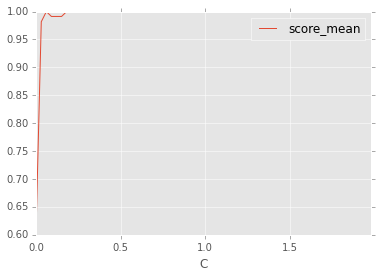

In [103]:
scores.plot(x='C', y='score_mean')

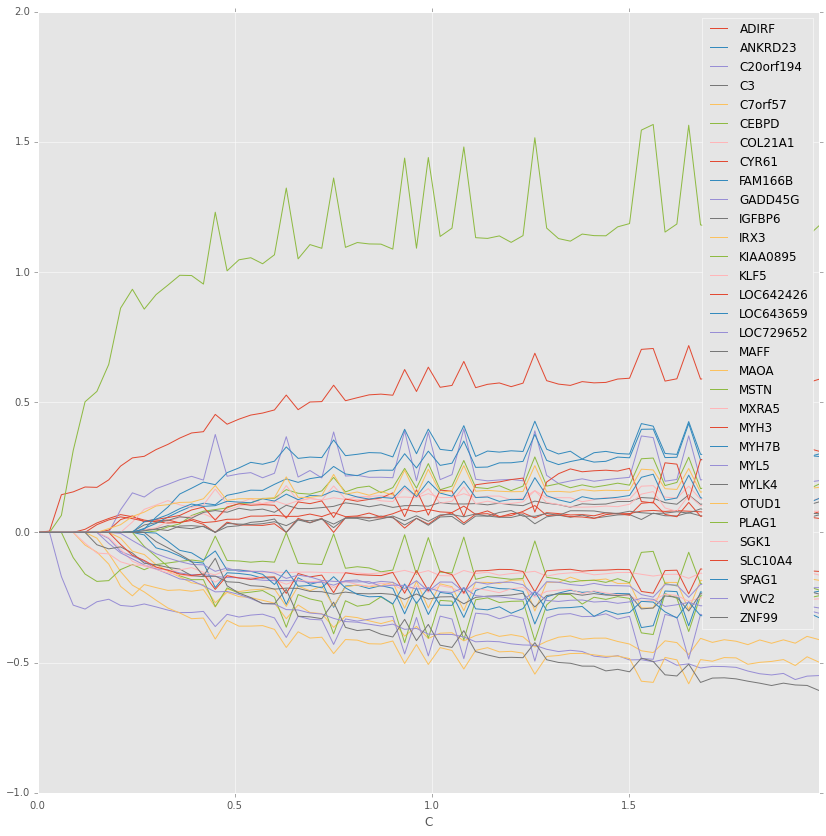

In [17]:
#%%
visualize_scores(scores)

### MIsc

In [30]:
def predict_plot(predicted, y):
        fig,ax = plt.subplots()
        ax.scatter(y, predicted)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        
        error_median = np.median(np.abs(y - predicted))
        print("Error median: {}".format(error_median))
        print("Corr: {}".format(
            pearsonr(predicted, y)
        ))
        
def score_model(model, X, y):
    predicted = cross_val_predict(model, X, y, cv=10)
    r2score = (1 - ((y - predicted) ** 2).sum() / ((y - y.mean())**2).sum())
    print("r2score: {}".format(r2score))
    
    predict_plot(predicted, y)

## Linear regression without regularization

In [84]:
ds.loc[paper_genes]

,GSM114642,GSM114643,GSM114644,GSM114645,GSM114646,GSM114647,GSM114648,GSM114649,GSM114650,GSM114651,...,GSM114713,GSM114714,GSM114715,GSM114716,GSM114717,GSM114718,GSM114719,GSM114720,GSM114721,GSM114722
symbol,,,,,,,,,,,,,,,,,,,,,
GDF8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GADD45G,139.718000,241.362000,170.228000,541.789000,150.841000,1835.850000,249.543000,242.752000,391.295000,612.448000,...,211.562000,890.977000,258.482000,235.286000,432.407000,1061.450000,773.198000,1647.660000,4546.900000,269.917000
LOC340156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYH4,843.630000,3129.480000,683.275000,526.345000,1618.190000,364.125000,2221.620000,1404.090000,3619.210000,3724.480000,...,1513.050000,1762.480000,1218.920000,2712.890000,1351.070000,2434.350000,2639.930000,2714.510000,2065.090000,1578.210000
ARRDC2,1843.320000,973.570000,873.248000,814.807000,835.526000,2099.560000,1107.790000,703.611000,1651.650000,1899.080000,...,949.616000,1318.860000,2000.060000,2269.330000,1259.890000,1751.370000,862.049000,618.070000,1898.020000,586.114000
NANOS1,246.796763,426.505415,332.765231,227.083807,657.498523,216.615707,355.635815,211.492100,814.011162,741.925077,...,316.125854,479.975702,263.025594,497.387404,672.899293,397.543423,573.199511,620.286757,481.010279,480.782140
MLF1,407.846310,670.445455,405.199972,335.598853,736.771993,426.368751,575.099303,191.667152,369.372443,675.224819,...,416.805056,788.529285,228.072804,569.759485,446.140349,497.720037,809.911589,1180.305544,505.906619,504.757928
PRKAG3,446.371000,717.042000,277.254000,215.028000,573.725000,443.473000,707.828000,222.744000,1324.510000,706.607000,...,285.251000,344.739000,227.812000,531.266000,410.401000,526.350000,361.236000,476.189000,367.269000,324.638000


r2score: -0.4299510573840517
Error median: 14.66381207710765
Corr: (0.57068076584332905, 2.6617810887737515e-08)


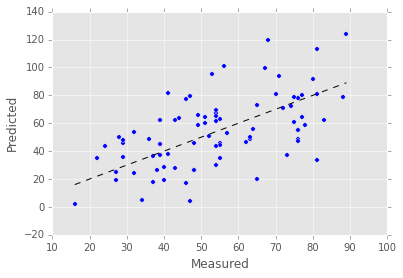

In [46]:
#%%
def cell():
    X = dslog2.loc[paper_genes].dropna().T.as_matrix()
    y = dslog2.T.index.map(lambda acc: characteristics.loc[acc]['age'])

    model = LinearRegression()
    score_model(model, X, y)
cell()
#     gene_lables = dslog2.index
#     _data = [(gene_lables[index], np.abs(coef)) for index, coef in enumerate(model.coef_)]
#     coefs_linear = pd.DataFrame.from_records(columns=['gene', 'coef'], data=_data).set_index('gene')
#     coefs_linear['r'] = coefs_linear.index.map(lambda x: np.abs(pearsonr(dslog2.loc[x].values, ages)[0]))

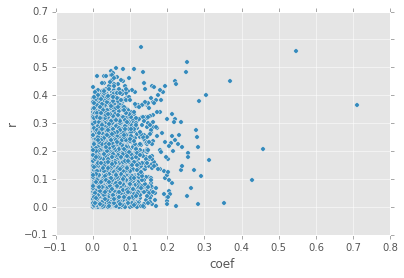

In [22]:
#%%
coefs_linear.plot(x='coef', y='r', kind='scatter')

In [23]:
#%%
cross_val_score(LinearRegression(), X, y, cv=5)

array([-0.80385682, -1.09412786, -1.36596523, -0.01845403, -0.43497226])

## Lasso regression

### Alpha plot

In [165]:
#%%
X = dslog2.T.as_matrix()
y = dslog2.T.index.map(lambda acc: characteristics.loc[acc]['age'])

def optimize_alpha(alpha):
    model = Lasso(alpha=alpha, normalize=False, max_iter=1000)
    scores = cross_val_score(model, X, y, cv=5)
    coef = model.fit(X, y).coef_.ravel()
    norm = np.linalg.norm(coef)
    sparsity = np.mean(coef == 0)
    genes_count = np.sum(coef != 0) 
    genes = [(i, c) for i, c in enumerate(coef) if c != 0]
    return (scores.mean(), scores.std(), norm, sparsity, genes_count, genes)


def foo():    
    scores_linear = pd.DataFrame(dict(alpha_1=np.arange(0.001, 3, 0.05 )))

    pool = Pool(3)
    _t = pd.DataFrame.from_records(pool.map(optimize_alpha, (1/scores_linear.alpha_1.values)))
    scores_linear[['score_mean', 'score_std', 'norm', 'sparsity', 'genes_count', 'genes']] = _t
    
    return scores_linear
scores_linear = foo()

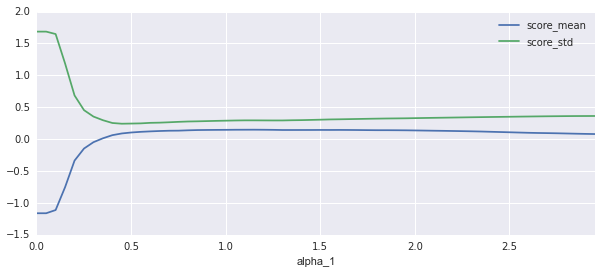

In [175]:
scores_linear.plot(x='alpha_1', y=['score_mean', 'score_std'])

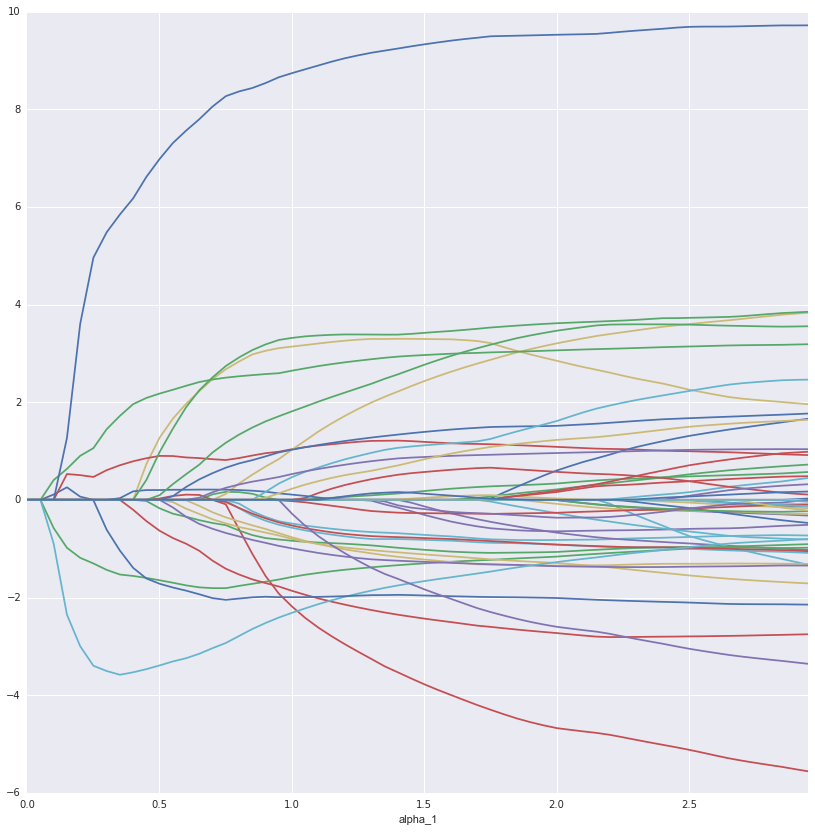

In [167]:
visualize_scores(scores_linear, score_key='alpha_1',score_value=3, threshold=0.0, legend=False)
    

### Prediction scores

r2score: 0.5392535906069773
Error median: 7.201449837934213
Corr: (0.73605974487676062, 4.9282303047350642e-15)


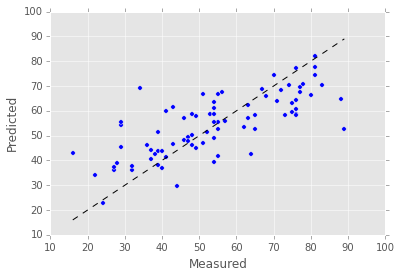

In [29]:
def predict_plot(predicted, y):
        fig,ax = plt.subplots()
        ax.scatter(y, predicted)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        
        error_median = np.median(np.abs(y - predicted))
        print("Error median: {}".format(error_median))
        print("Corr: {}".format(
            pearsonr(predicted, y)
        ))
def cell():
    X = dslog2.T.as_matrix()
    y = dslog2.T.index.map(lambda acc: characteristics.loc[acc]['age'])
    model = Lasso(alpha=1, normalize=False, max_iter=1000)
#     predicted = cross_val_predict(model, X, y, cv=10)
#     r2score = (1 - ((y - predicted) ** 2).sum() / ((y - y.mean())**2).sum())
#     print("r2score: {}".format(r2score))
    
#     predict_plot(predicted, y)
    score_model(model, X, y)
cell()

### Training set scoring

Error median: 4.734598715770801
Corr: (0.93041083808321534, 3.5140481080785819e-36)
r2score: 0.8396703451102094


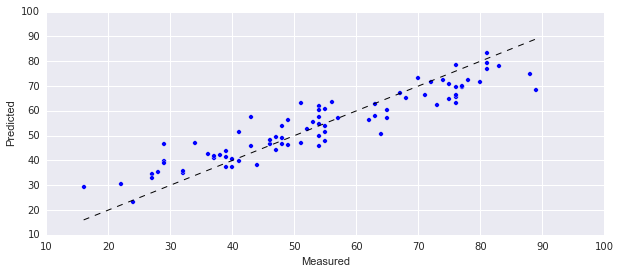

In [174]:
def cell():
    X = dslog2.T.as_matrix()
    y = dslog2.T.index.map(lambda acc: characteristics.loc[acc]['age'])
    model = Lasso(alpha=1, normalize=False, max_iter=1000)
    predicted = model.fit(X, y).predict(X)
    predict_plot(predicted, y)
    r2score = (1 - ((y - predicted) ** 2).sum() / ((y - y.mean())**2).sum())
    print("r2score: {}".format(r2score))

cell()

### Correlation between genes in lasson non-null coefs and age

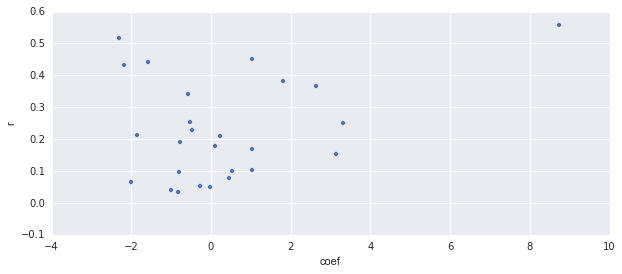

In [160]:
def cell():
    X = dslog2.T.as_matrix()
    y = dslog2.T.index.map(lambda acc: characteristics.loc[acc]['age'])

    model = Lasso(alpha=1, max_iter=2000)
    model.fit(X, y)
    _coef = model.coef_
    lasso_coefs = pd.DataFrame.from_records(columns=['gene', 'coef'], 
                                            data=list(zip(dslog2.index.tolist(), _coef)))
    lasso_coefs = lasso_coefs[lasso_coefs['coef'] != 0]
    lasso_coefs['r'] = lasso_coefs.gene.map(lambda x: np.abs(pearsonr(dslog2.loc[x].values, ages)[0]))
    lasso_coefs.plot(x='coef', y='r', kind='scatter')
    
cell()

In [161]:
lasso_coefs['in_paper'] = lasso_coefs.gene.isin(paper_down_ages+paper_up_ages)
lasso_coefs.sort(columns='in_paper')

,gene,coef,r,in_paper
701,ANKRD23,-2.180170,0.433290,False
14475,PSMA8,3.316277,0.250777,False
12789,NUPR1,0.462540,0.077552,False
12043,MYOG,-0.279006,0.051625,False
11994,MYH8,-0.026242,0.049658,False
11954,MXRA5,-1.993715,0.066719,False
11839,MSTN,-2.315196,0.518471,False
11062,MAOA,-0.993352,0.039717,False
10676,LOC729652,-0.525062,0.253889,False
10606,LOC643659,1.811798,0.381142,False


### Heatmap

In [86]:
def code():
    X_train = np.array([[ 1., -1.,  2.],
                        [ 2.,  0.,  0.],
                        [ 0.,  1., -10]])
    return preprocessing.MinMaxScaler().fit_transform(X_train.T).T
code()

array([[ 0.66666667,  0.        ,  1.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.90909091,  1.        ,  0.        ]])

In [112]:
import seaborn
seaborn.mpl.rc("figure", figsize=(10,4))

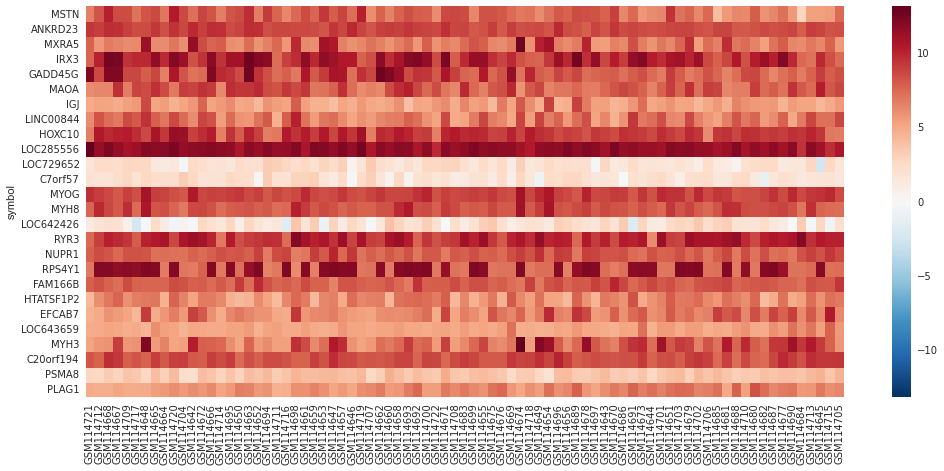

In [98]:
from sklearn import preprocessing

def genes_heatmap(genes):
    age_genes = dslog2.loc[genes][characteristics.sort(columns='age').index]
    age_genes = pd.DataFrame(
                             data=age_genes, #preprocessing.MinMaxScaler().fit_transform(age_genes.T).T, 
                             columns=age_genes.columns, 
                             index=age_genes.index)

    seaborn.heatmap(age_genes)
genes_heatmap(lasso_coefs.sort(columns=['coef']).gene)

## Gene from age regr analysis

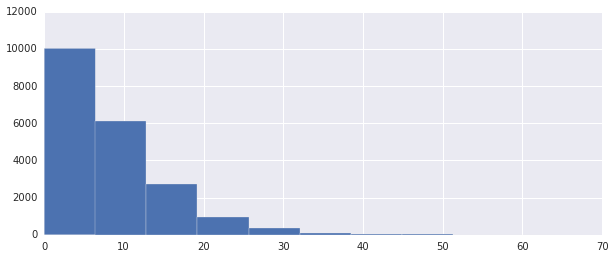

In [113]:
def code():
    model = LinearRegression()

    def calc_scores(in_):
        gene, gene_samples = in_
        model.fit(gene_samples.values[None].T, ages)
        return model.intercept_, model.coef_[0]

    revese_scores = list(map(calc_scores , dslog2.dropna().iterrows()))
    scores2 = pd.DataFrame.from_records(data=revese_scores, columns=['c1', 'c2'], index=dslog2.dropna().index)
    scores2.c2.abs().hist()
    return scores2
scores2 = code()

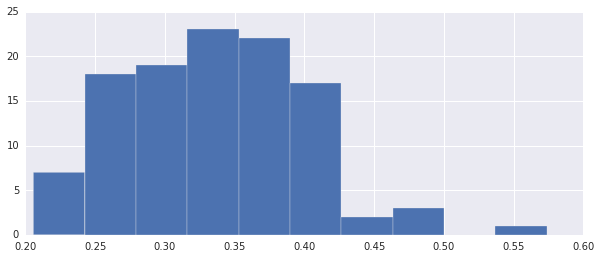

In [114]:
#%%
genes2 = scores2[scores2.c2.abs() > 35].index

corr2 = pd.DataFrame()
corr2['gene'] = genes2
corr2['r'] = np.abs(corr2.gene.map(lambda x: pearsonr(dslog2.loc[x].values, ages)[0]))
corr2.r.hist()
#calc_scores(ds.iloc[1])
#ds.itertuples()

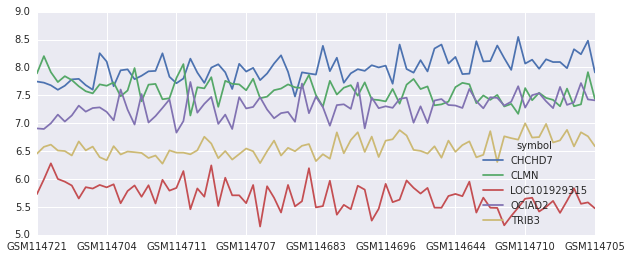

In [137]:
_t = dslog2[characteristics.sort(columns='age').index].loc[corr2[corr2.r> 0.45].gene]
_t = pd.DataFrame(data=_t, columns=_t.columns, index=_t.index)
_t.T.plot()

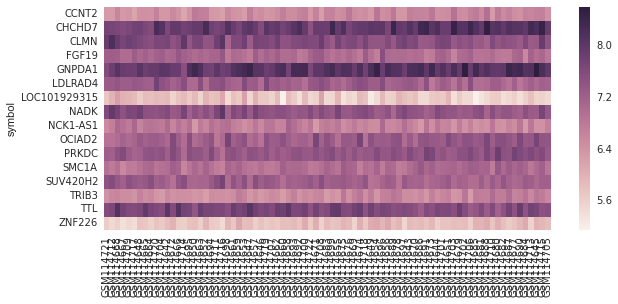

In [136]:
genes_heatmap(corr2[corr2.r> 0.4].gene)

In [103]:
corr2[corr2.r> 0.4].sort(columns='r')

,gene,r
89,SUV420H2,0.400371
102,TTL,0.402570
108,ZNF226,0.407461
55,NADK,0.409968
11,CCNT2,0.412132
83,SMC1A,0.412154
70,PRKDC,0.415362
28,FGF19,0.418051
33,GNPDA1,0.420115
41,LDLRAD4,0.420257
